In [9]:
import cv2
import numpy as np
import time
from scipy.sparse import linalg 
from scipy.sparse import lil_matrix 
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#確定index在區域之內或之外
def in_region(index, mask):
    return mask[index] == 1

#上下左右index
def cruciform(index):
    x, y = index
    return [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]

#確定index有無在邊界上
def boundary(index, mask):
    if in_region(index, mask) == False:
        return False
    for p in cruciform(index):
        if in_region(p, mask) == False:
            return True
    return False    

In [11]:
def pointpos(index, mask):
    if in_region(index, mask) == False:
        return 2
    if boundary(index, mask) == True:
        return 1
    return 0

def laplacian_(src, index):
    x, y = index
    value = (4 * src[x, y]) - (1 * src[x+1, y]) - (1 * src[x-1, y]) - (1 * src[x, y+1]) - (1 * src[x, y-1])
    return value

def region_mask(mask):
    nonzero = mask.nonzero()
    return list(zip(nonzero[0], nonzero[1]))

##============create sparse matrix===============##
def sparse_mat(p):
    num = len(p)  #mask中點的數量
    MatA = lil_matrix((num, num))
    for i,index in enumerate(p):
        MatA[i, i] = 4
        for m in cruciform(index):
            if m not in p:
                continue
            j = p.index(m)
            MatA[i, j] = -1
    return MatA

In [12]:
def solver(src, dst, mask):
    pointer = region_mask(mask)
    num = len(pointer)
    
##=============create A matrix=================##    
    MatA = sparse_mat(pointer)
##=============create b matrix=================##
    Matb = np.zeros(num)
    
    for i, index in enumerate(pointer):
        Matb[i] = laplacian_(src, index) 
        
        if pointpos(index, mask) == 1:
            for p in cruciform(index):
                if in_region(p, mask) == False:
                    Matb[i] += dst[p]
##=============solve x===================##                    
    Matx = linalg.cg(MatA, Matb)
    copydst = np.copy(dst).astype(int)
    
    for i, index in enumerate(pointer):
        copydst[index] = Matx[0][i]
    return copydst    

In [37]:
#start = time.time()

##=============load image =================##

imgsrc = cv2.imread("img/bear.jpg", cv2.IMREAD_COLOR)
imgdst = cv2.imread("img/pool-target.jpg", cv2.IMREAD_COLOR)
imgmask = cv2.imread("img/bear-mask.jpg", cv2.IMREAD_GRAYSCALE)
offset = (0, 5)

print('Source image size:', imgsrc.shape[:-1])
#plt.imshow(imgsrc[:,:,::-1]) # this is a trick to display the image in here 
#plt.show()
print('Target image size:', imgdst.shape[:-1])
#plt.imshow(imgdst[:,:,::-1])
#plt.show()
print('Mask size:', imgmask.shape)
#plt.imshow(imgmask, cmap='gray')
#plt.show()


Source image size: (107, 130)
Target image size: (333, 250)
Mask size: (107, 130)


Source image size: (333, 250)


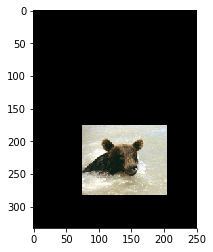

In [38]:
y_max, x_max = imgdst.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

for i in range(0, 20):
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    imgsrc = cv2.warpAffine(imgsrc, M, (x_range, y_range))
    imgmask = cv2.warpAffine(imgmask, M, (x_range, y_range))
for i in range(0, 15):
    M = np.float32([[1, 0, offset[1]], [0, 1, offset[1]]])
    imgsrc = cv2.warpAffine(imgsrc, M, (x_range, y_range))
    imgmask = cv2.warpAffine(imgmask, M, (x_range, y_range))    

print('Source image size:', imgsrc.shape[:-1])
plt.imshow(imgsrc[:,:,::-1]) 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


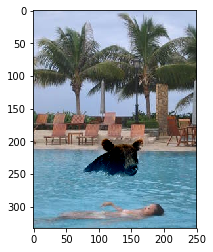

Execution time: 16.51[secs]


True

In [40]:
#normaliz
start = time.time()
mask = np.atleast_3d(imgmask).astype(np.float) / 255.
mask[mask != 1] = 0

#one channel 

mask = mask[:, :, 0]
channel = imgsrc.shape[-1]

#每個channel都解

result_stack = [solver(imgsrc[:, :, i], imgdst[:, :, i], mask) for i in range(channel)]

result = cv2.merge(result_stack)

plt.imshow(result[:,:,::-1]) 
plt.show()

end = time.time()

print("Execution time: {0}[secs]".format(round(end - start, 2)))
cv2.imwrite("output/result5.png", result)


In [19]:
#======================= One ==========================#
onestart = time.time()

onesrc = cv2.imread("img/einsteinSample.bmp")
onemask = cv2.imread("img/einsteinMask.bmp",0)

onedst = cv2.inpaint(onesrc, onemask, 3, cv2.INPAINT_TELEA)

oneend = time.time()

print("Execution time: {0}[secs]".format(round(oneend - onestart, 2)))

cv2.imwrite("output/oneresult.png", onedst)

Execution time: 0.53[secs]


True